In [1]:
#Import the Libraries
from bs4 import BeautifulSoup
import requests
import smtplib
import time
import datetime

## How to save HTML locally
After we make a request and retrieve a web page's content, we can store that content locally with python's Open() funcation.To do so we need to use the argument Wb which stands for "Write bytes

In [2]:
def save_html(html, path):
    with open(path,'wb') as f:
        f.write(html)
        
    

## How to open/read HTML from a local file
To retrive our saved file we'll make another funcation to wrap reading the html back into html.we need to use rb for "read bytes" in this case.

In [3]:
def open_html(path):
    with open(path,'rb') as f:
        return f.read()

## Making web requests
with Python's requests library we're getting a web page by using get() on the URL. The response __r__ contains many things but using __r.content__ will give us the HTML

In [4]:
import requests

url = 'https://www.allsides.com/media-bias/media-bias-ratings'

r = requests.get(url)

content = r.text
print(content)

<!DOCTYPE html>
<html  lang="en" dir="ltr" prefix="og: http://ogp.me/ns# content: http://purl.org/rss/1.0/modules/content/ dc: http://purl.org/dc/terms/ foaf: http://xmlns.com/foaf/0.1/ rdfs: http://www.w3.org/2000/01/rdf-schema# sioc: http://rdfs.org/sioc/ns# sioct: http://rdfs.org/sioc/types# skos: http://www.w3.org/2004/02/skos/core# xsd: http://www.w3.org/2001/XMLSchema#">
<head profile="http://www.w3.org/1999/xhtml/vocab">
<meta charset="utf-8" />
<link rel="shortcut icon" href="https://www.allsides.com/sites/default/files/AllSides-Icon.png" type="image/png" />
<meta property="fb:app_id" content="555035668344688" />
<meta name="description" content="What’s the bias of your favorite media outlet? See over 800 AllSides media bias ratings." />
<meta name="keywords" content="media bias ratings chart, media bias ratings allsides, news media bias ratings, media outlet bias ratings, media bias ratings website" />
<link rel="canonical" href="https://www.allsides.com/media-bias/media-bias-

### What does BeautifulSoup do?
BeautifulSoup library to parase HTML and XML. when we pass our HTML to the BeautifulSoup constructor we get an Object in return that we can then navigate like the original tree structure of the DOM

In [5]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(r.content,'html.parser')

This soup object defines a bunch of methods- many of which can achieve the same result- that we can use to extract data from the html. 
### Finding elements and data
To find elements and data inside our HTML We'll be using select_one which returns a single elements and select, which returns a list of elements(even if only one item exists) Both of these methods use CSS selectores to find elements

In [6]:
rows = soup.select('tbody tr')

tbody tr tells the selector to extract all <tr> (table row) tags that are children of the <tbody> body tag. if there where more than one table on this page we would have to make a more specific selector,but since this is the only one table we're good to go 

In [7]:
row = rows[0]
name = row.select_one('.source-title').text.strip()
print(name)

ABC News (Online)


**Notic** that we didn't need to worry about selecting the anchor tag a that contains the text when we use .text is gets all text in that element, and since" ABC News (Online) is the only text that's all we need to do.Bear in mind that using select or select_one will give you the whole element with the tags include, so we need .text to give us the text between the tags<br>
.strip() ensures all the whitespace surrounding the name is removed

### New Source (online) page link 
We also need the link to this news source's (online) page on AllSides if we look back at the HTML we'll see that in this case we do want to select the anchor in order to get the href that contains the link so lets do that

In [8]:
allsides_page = row.select_one('.source-title a')['href']
allsides_page = 'https://www.allsides.com' + allsides_page

print(allsides_page)

https://www.allsides.com/news-source/abc-news-media-bias


## Bias Rating
we can see that the rating is displayed as an image so how can we get the rating in word? looking at the html notice the link that surrounding the image has the text we need <br>
<tb>we could also pull the alt attribute but the link looks easier</tb>

In [9]:
bias = row.select_one('.views-field-field-bias-image a')['href']
bias = bias.split('/')[-1]
print(bias)

left-center


Here we selected the anchor tag by using the class name and tag together: .views-field-field-bias-image is the class of the  <<tb>
    td > and < a>
    is for the anchor nested inside.

After that we extract the href just like before, but now we only want the last part of the URL for the name of the bias so we split on slashes and get the last element of that split (left-center).

## Community feedback data
The number we want are located in two span elements in the last div. Both span elements have classes that are unique in this cell so we can use them to make the slection


In [10]:
agree = row.select_one('.agree').text
agree = int(agree)

#using .text will return a string, so we need convert them to integer in order to calcilate the ratio

disagree = row.select_one('.disagree').text
disagree = int(disagree)

agree_ration = agree/disagree

print(f"Agree: {agree}, Disagrre : {disagree}, Agree_Ratio : {agree_ration}")

Agree: 34803, Disagrre : 17701, Agree_Ratio : 1.9661601039489294


In [11]:
def get_agreeance_text(ratio):
    if ratio > 3: return "absolutely agrees"
    elif 2 < ratio <=3 : return "strongly agrees"
    elif 1.5 < ratio <=2 : return "agrees"
    elif 1 < ratio <=1.5 : return "somewhat agrees"
    elif ratio == 1 : return "neutral"
    elif 0.67 < ratio < 1 : return "somewhat disagree"
    elif 0.5 < ratio <=0.67 : return "disagree"
    elif 0.33 < ratio <=0.5 : return "strongly disagree"
    elif ratio <=0.33: return "absolutely disagrees"
    else : return None


__Now that we have the general logic for a single row and we can generate the agreeance text, let's create a loop that gets data from every row on the first page:__

In [12]:
data= []

for row in rows:
    d = dict()
    
    d['name'] = row.select_one('.source-title').text.strip()
    d['allsides_page'] = 'https://www.allsides.com' + row.select_one('.source-title a')['href']
    d['bias'] = row.select_one('.views-field-field-bias-image a')['href'].split('/')[-1]
    d['agree'] = int(row.select_one('.agree').text)
    d['disagree'] = int(row.select_one('.disagree').text)
    d['agree_ratio'] = d['agree'] / d['disagree']
    d['agreeance_text'] = get_agreeance_text(d['agree_ratio'])
    
    data.append(d)

In [13]:
print(data[0])

{'name': 'ABC News (Online)', 'allsides_page': 'https://www.allsides.com/news-source/abc-news-media-bias', 'bias': 'left-center', 'agree': 34803, 'disagree': 17701, 'agree_ratio': 1.9661601039489294, 'agreeance_text': 'agrees'}


## Requesting and parsing multiple pages
Notice that the URLs for each page follow a pattern.The first page has no parameters on the URL, but the next pages do; specifically they attach a ? page=# to the URL where '#' is the page number

In [24]:

pages = [
    'https://www.allsides.com/media-bias/media-bias-ratings?field_featured_bias_rating_value=All&field_news_source_type_tid[1]=1&field_news_source_type_tid[2]=2&field_news_source_type_tid[3]=3&field_news_source_type_tid[4]=4',
    #'https://www.allsides.com/media-bias/media-bias-ratings?page=1',
    #'https://www.allsides.com/media-bias/media-bias-ratings?page=2'
]

In [25]:
from time import sleep

data= []

for page in pages:
    r = requests.get(page)
    soup = BeautifulSoup(r.content, 'html.parser')
    
    rows = soup.select('tbody tr')

    for row in rows:
        d = dict()

        d['name'] = row.select_one('.source-title').text.strip()
        d['allsides_page'] = 'https://www.allsides.com' + row.select_one('.source-title a')['href']
        d['bias'] = row.select_one('.views-field-field-bias-image a')['href'].split('/')[-1]
        d['agree'] = int(row.select_one('.agree').text)
        d['disagree'] = int(row.select_one('.disagree').text)
        d['agree_ratio'] = d['agree'] / d['disagree']
        d['agreeance_text'] = get_agreeance_text(d['agree_ratio'])

        data.append(d)
    
    sleep(10)

In [27]:
data

[{'name': 'Aaron Rupar',
  'allsides_page': 'https://www.allsides.com/news-source/aaron-rupar-media-bias',
  'bias': 'left',
  'agree': 53,
  'disagree': 31,
  'agree_ratio': 1.7096774193548387,
  'agreeance_text': 'agrees'},
 {'name': 'Aaron Withe',
  'allsides_page': 'https://www.allsides.com/news-source/aaron-withe-media-bias',
  'bias': 'right',
  'agree': 57,
  'disagree': 40,
  'agree_ratio': 1.425,
  'agreeance_text': 'somewhat agrees'},
 {'name': 'AARP',
  'allsides_page': 'https://www.allsides.com/news-source/aarp-media-bias',
  'bias': 'center',
  'agree': 1844,
  'disagree': 3755,
  'agree_ratio': 0.4910785619174434,
  'agreeance_text': 'strongly disagree'},
 {'name': 'ABC News (Online)',
  'allsides_page': 'https://www.allsides.com/news-source/abc-news-media-bias',
  'bias': 'left-center',
  'agree': 34807,
  'disagree': 17705,
  'agree_ratio': 1.965941824343406,
  'agreeance_text': 'agrees'},
 {'name': 'Above The Law',
  'allsides_page': 'https://www.allsides.com/news-sour

In [28]:
from tqdm import tqdm_notebook

for d in tqdm_notebook(data):
    r = requests.get(d['allsides_page'])
    soup = BeautifulSoup(r.content, 'html.parser')
    
    try:
        website = soup.select_one('.www')['href']
        d['website'] = website
    except TypeError:
        pass
    
    sleep(10)

<ipython-input-28-a6c8fca3f238>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for d in tqdm_notebook(data):


## saving our data

In [29]:
import json
with open ('allsides.json','w') as f:
    json.dump(data,f)

In [30]:
with open ('allsides.json','r') as f:
    data = json.load(f)

## Brief Data Analysis
**Which rating for outlets does the community absolutely agree on?**<br>
<br>
to find where the community absolute agree we can do simple list comprehension that checks each dict for the agreeance text we want:


In [31]:

abs_agree = [d for d in data if d['agreeance_text'] == 'absolutely agrees']

print(f"{'Outlet':<20} {'Bias':<20}")
print("-" * 30)

for d in abs_agree:
    print(f"{d['name']:<20} {d['bias']:<20}")

Outlet               Bias                
------------------------------
AJ+                  left                
AlterNet             left                
Ann Coulter          right               


In [33]:
import pandas as pd 
df = pd.read_json(open('allsides.json','r'))
df.set_index('name',inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Aaron Rupar to Axios
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   allsides_page   50 non-null     object 
 1   bias            50 non-null     object 
 2   agree           50 non-null     int64  
 3   disagree        50 non-null     int64  
 4   agree_ratio     50 non-null     float64
 5   agreeance_text  50 non-null     object 
dtypes: float64(1), int64(2), object(3)
memory usage: 2.7+ KB


In [34]:
df[df['agreeance_text'] == 'strongly disagrees']

,allsides_page,bias,agree,disagree,agree_ratio,agreeance_text
name,,,,,,


In [35]:
df['total_votes'] = df['agree'] + df['disagree']
df.sort_values('total_votes', ascending=False, inplace=True)

df.head(10)

,allsides_page,bias,agree,disagree,agree_ratio,agreeance_text,total_votes
name,,,,,,,
ABC News (Online),https://www.allsides.com/news-source/abc-news-...,left-center,34807,17705,1.965942,agrees,52512
Associated Press,https://www.allsides.com/news-source/associate...,center,26215,20124,1.302673,somewhat agrees,46339
AlterNet,https://www.allsides.com/news-source/alternet-...,left,13372,2875,4.651130,absolutely agrees,16247
Al Jazeera,https://www.allsides.com/news-source/al-jazeer...,left-center,4857,7344,0.661356,disagree,12201
Axios,https://www.allsides.com/news-source/axios,center,5844,6185,0.944867,somewhat disagree,12029
AllSides,https://www.allsides.com/news-source/allsides,allsides,4182,1649,2.536082,strongly agrees,5831
AARP,https://www.allsides.com/news-source/aarp-medi...,center,1844,3755,0.491079,strongly disagree,5599
ACLU,https://www.allsides.com/news-source/american-...,left-center,2065,3082,0.670019,somewhat disagree,5147
AllSides Community,https://www.allsides.com/news-source/allsides-...,allsides,2625,1499,1.751167,agrees,4124


In [36]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

In [37]:
df2 = df.head(25).copy()

df2.head()

,allsides_page,bias,agree,disagree,agree_ratio,agreeance_text,total_votes
name,,,,,,,
ABC News (Online),https://www.allsides.com/news-source/abc-news-...,left-center,34807,17705,1.965942,agrees,52512
Associated Press,https://www.allsides.com/news-source/associate...,center,26215,20124,1.302673,somewhat agrees,46339
AlterNet,https://www.allsides.com/news-source/alternet-...,left,13372,2875,4.651130,absolutely agrees,16247
Al Jazeera,https://www.allsides.com/news-source/al-jazeer...,left-center,4857,7344,0.661356,disagree,12201
Axios,https://www.allsides.com/news-source/axios,center,5844,6185,0.944867,somewhat disagree,12029


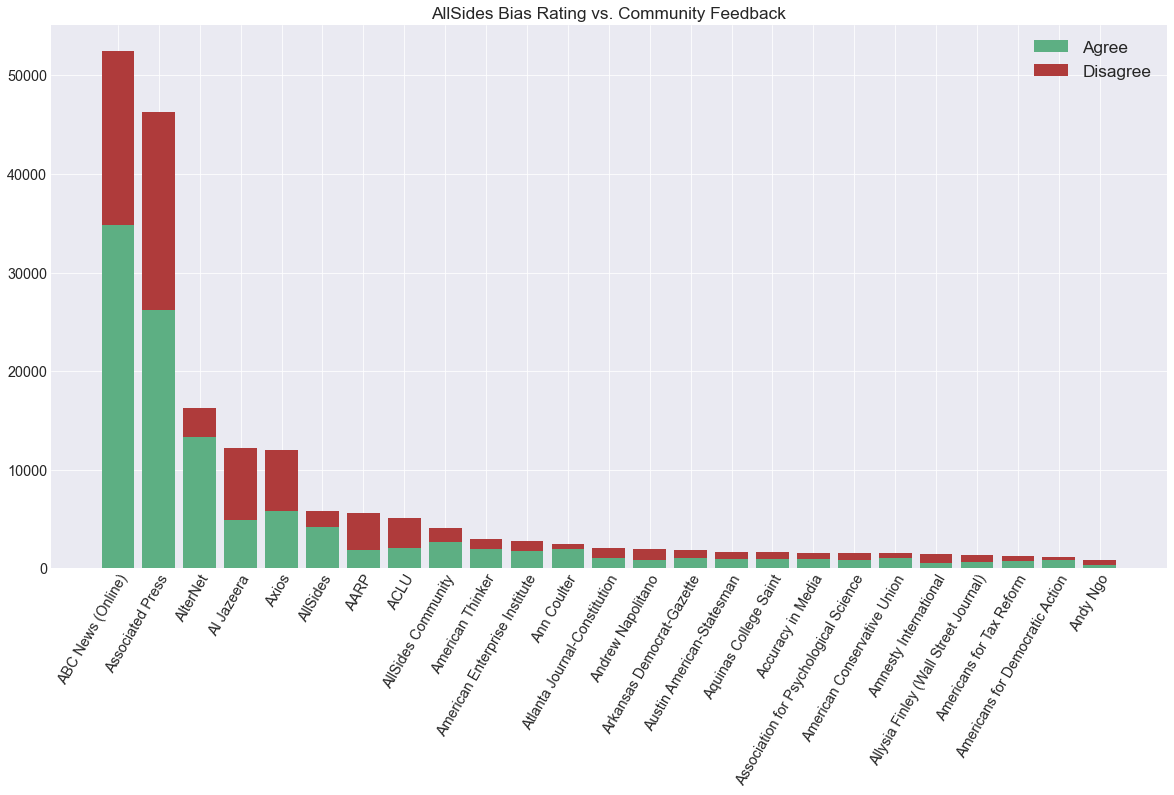

In [38]:
fig, ax = plt.subplots(figsize=(20, 10))

ax.bar(df2.index, df2['agree'], color='#5DAF83')
ax.bar(df2.index, df2['disagree'], bottom=df2['agree'], color='#AF3B3B')

ax.set_ylabel = 'Total feedback'

plt.yticks(fontsize='x-large')
plt.xticks(rotation=60, ha='right', fontsize='x-large', rotation_mode='anchor')

plt.legend(['Agree', 'Disagree'], fontsize='xx-large')
plt.title('AllSides Bias Rating vs. Community Feedback', fontsize='xx-large')
plt.show()

<ipython-input-39-5600b87ff47c>:16: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(len(biases) / 2, 2, i + 1)


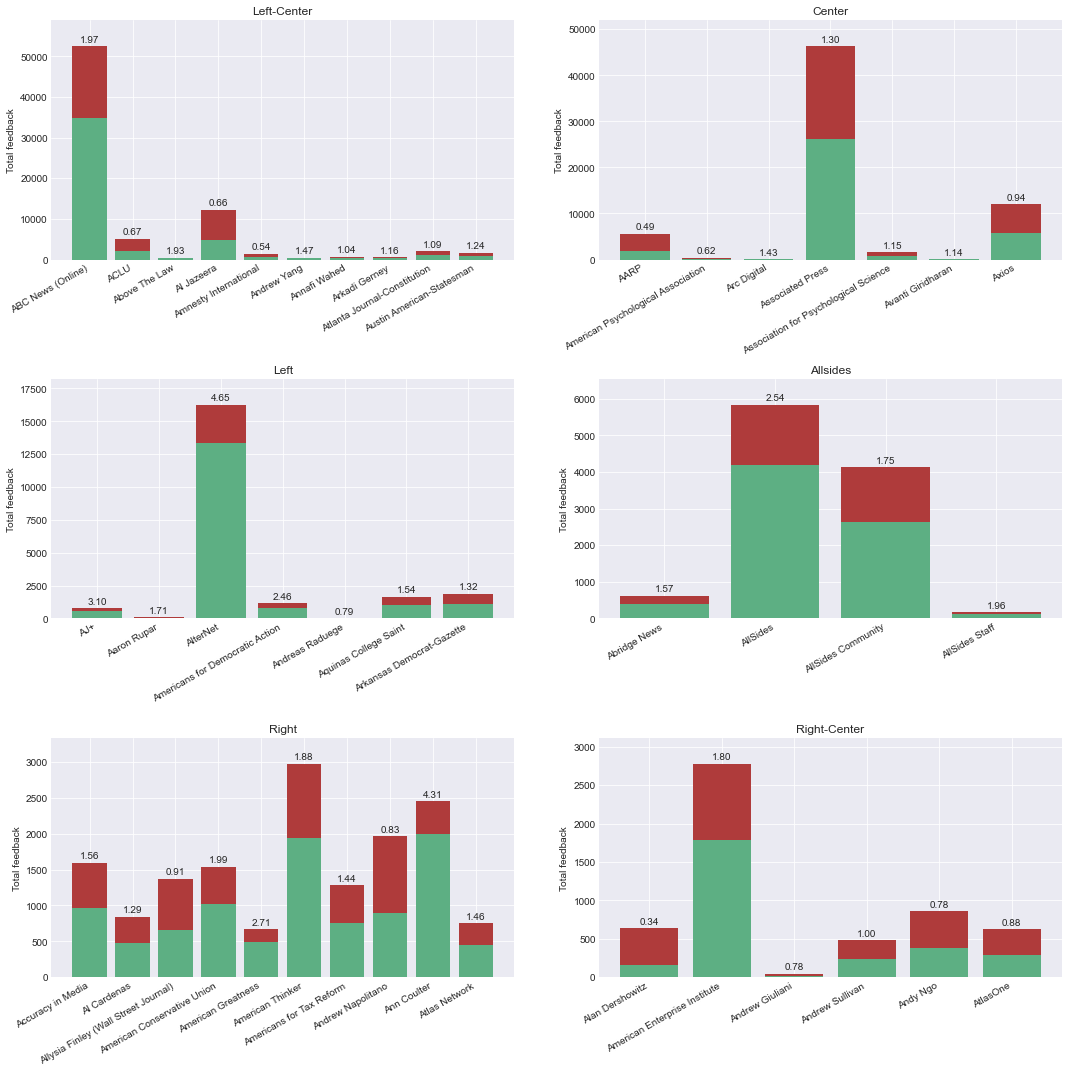

In [39]:
df3 = df.copy()

fig = plt.figure(figsize=(15,15))

biases = df3['bias'].unique()

for i, bias in enumerate(biases):
    # Get top 10 news sources for this bias and sort index alphabetically
    temp_df = df3[df3['bias'] == bias].iloc[:10]
    temp_df.sort_index(inplace=True)
    
    # Get max votes, i.e. the y value for tallest bar in this temp dataframe
    max_votes = temp_df['total_votes'].max()
    
    # Add a new subplot in the correct grid position
    ax = fig.add_subplot(len(biases) / 2, 2, i + 1)
    
    # Create the stacked bars
    ax.bar(temp_df.index, temp_df['agree'], color='#5DAF83')
    ax.bar(temp_df.index, temp_df['disagree'], bottom=temp_df['agree'], color='#AF3B3B')
    
    # Place text for the ratio on top of each bar
    for x, y, ratio in zip(ax.get_xticks(), temp_df['total_votes'], temp_df['agree_ratio']):
        ax.text(x, y + (0.02 * max_votes), f"{ratio:.2f}", ha='center')
    
    ax.set_ylabel('Total feedback')
    ax.set_title(bias.title())
    
    # Make y limit larger to compensate for text on bars
    ax.set_ylim(0, max_votes + (0.12 * max_votes))
    
    # Rotate tick labels so they don't overlap
    plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

plt.tight_layout(w_pad=3.0, h_pad=1.0)
plt.show()

In [40]:
df2 = df.copy()

In [41]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, ABC News (Online) to Arc Digital
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   allsides_page   50 non-null     object 
 1   bias            50 non-null     object 
 2   agree           50 non-null     int64  
 3   disagree        50 non-null     int64  
 4   agree_ratio     50 non-null     float64
 5   agreeance_text  50 non-null     object 
 6   total_votes     50 non-null     int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 3.1+ KB


In [42]:
df2.drop('allsides_page',axis='columns',inplace=True)

In [43]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, ABC News (Online) to Arc Digital
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bias            50 non-null     object 
 1   agree           50 non-null     int64  
 2   disagree        50 non-null     int64  
 3   agree_ratio     50 non-null     float64
 4   agreeance_text  50 non-null     object 
 5   total_votes     50 non-null     int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 2.7+ KB


In [44]:
df2.to_csv('media_ Ratings.csv')